Hello everyone,

In this project, it is required to implement an Arabic Font Identification System that will be able to identify the font for a given Arabic text snippet.
We will work with the [(ACdb) Arabic Calligraphy Database](https://drive.google.com/file/d/1dC7pwzT_RHL9B42H8-Nzf5Sant-86NV6/view) containing 9 categories of computer printed Arabic text snippets.

At first, what are the main steps we should go through in this project?

# TODOs:

1. Understand the problem (look at the big picture)
2. Get the data
3. Preprocessing
4. Extract features  
5. Features evaluation
6. Style Recognition
7. Result

# 1. Understand the problem

*What is the objective?* Despite this question appears so easy, but it is very important..

Here, the objective is --

So, we need to build a predictive model with:

- Input: --
- Output: --

In [266]:
# importing io module
import sys
# from io_utils.io_utils import read_data, read_classes, split_data
# from preprocessing.preprocessing import binarize, extract_skeleton, extract_edges, crop, separate_diacritics_and_text
# from feature_extraction.feature_extraction import Tth, SDs, WOr, LVL, HVSL, ToE_ToS, HPP 
from io_utils import io_utils
from preprocessing import preprocessing
from feature_extraction import feature_extraction 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Get the data

After downloading and uncompressing the dataset, we will import it using --:

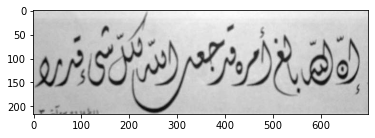

In [265]:
data, labels = io_utils.read_data("./ACdata_base")
classes_names = io_utils.read_classes('./ACdata_base/names.txt')
plt.imshow(data[0], cmap="gray")
plt.show()

In [300]:
data_train, data_test, labels_train, labels_test = io_utils.split_data(data, labels, test_size=0.3)
data_validation, data_test, labels_validation, labels_test = io_utils.split_data(data_test, labels_test, test_size=0.33)

print(f'total       data size: {len(data)} ({round(100*len(data)/len(data),2)}%)')
print(f'training    data size: {len(data_train)} ({round(100*len(data_train)/len(data),2)}%)')
print(f'validation  data size: {len(data_validation)} ({round(100*len(data_validation)/len(data),2)}%)')
print(f'testing     data size: {len(data_test)} ({round(100*len(data_test)/len(data),2)}%)')

total       data size: 1685 (100.0%)
training    data size: 1179 (69.97%)
validation  data size: 339 (20.12%)
testing     data size: 167 (9.91%)



# 3. Preprocessing

In [4]:
def preprocessing_pipline(img, separate_diacritics=True):
    """apply preprocessing stages
        
    Args:
        image: grayscale image
    Returns:
        cropped_img: cropped image
        edge_img: edge image
        skeleton_img: skeleton image
        diacritics_img: diacritics only image
        text_img: text only image
    """

    binary_img = preprocessing.binarize(img)
    cropped_img = preprocessing.crop(binary_img)
    edge_img = preprocessing.extract_edges(cropped_img)
    skeleton_img = preprocessing.extract_skeleton(cropped_img)
    diacritics_img, text_img = None, None
    if separate_diacritics:
        diacritics_img, text_img = preprocessing.separate_diacritics_and_text(cropped_img)
    
    return cropped_img, edge_img, skeleton_img, diacritics_img, text_img


# 4. Extract features

In [183]:
def feature_extraction_pipeline(cropped_img, edge_img, skeleton_img, diacritics_img, text_img):
    """apply feature extraction stages
    Args:
        cropped_img: cropped image
        edge_img: edge image
        skeleton_img: skeleton image
        diacritics_img: diacritics only image
        text_img: text only image
    Returns:
        hvsl, toe, tos, lvl, tth, sds, wor, hpp
    """    
    hvsl = feature_extraction.HVSL(edge_img)
    toe = feature_extraction.ToE_ToS(edge_img,12) #12
    tos = feature_extraction.ToE_ToS(skeleton_img,10) #10
    lvl = feature_extraction.LVL(skeleton_img)
    tth = feature_extraction.Tth(skeleton_img, edge_img, 10) #10
    sds = feature_extraction.Diacritics(diacritics_img)
    wor = feature_extraction.WOr(text_img)
    hpp = feature_extraction.HPP(cropped_img) #13

    return hvsl, toe, tos, lvl, tth, sds, wor, hpp

In [6]:
def preprocessing_feature_extraction_pipeline(data, one_feature_vector=True):
    data_features = [[] for i in range(0,8)]
    for element in data:
        preprocessed = preprocessing_pipline(element)
        features = feature_extraction_pipeline(preprocessed[0], preprocessed[1], preprocessed[2], preprocessed[3], preprocessed[4])
        for i, feature in enumerate(features):
            data_features[i].append((feature))

    for i in range(len(data_features)):
        data_features[i] = np.vstack(data_features[i])

    if one_feature_vector:
        data_features = np.hstack(data_features)
        
    return data_features
            


# 5. Features evaluation

In [7]:
from statistics import median
from sklearn.model_selection import cross_val_score

def cross_val_classifiers(X, Y, clfs, labels=None):
    scores = []
    best_median_score = 0
    best_clf_idx = 0
    for i in range(len(clfs)):
        score = cross_val_score(clfs[i], X, Y)
        scores.append(score)
        m = median(score)
        if m > best_median_score:
            best_median_score = m
            best_clf_idx = i
    
    if labels is None:
        labels = clfs
        
    scores_df = pd.DataFrame(columns=labels, data=np.array(scores).T)
    return scores_df, best_clf_idx

## Word Orientation

In [47]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_wor = feature_extraction.WOr(text_img)
    data_features.append(features_wor)

data_features = np.array(data_features)            

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
score_wor,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["Wor only with Random Forest"])

In [49]:
# m 2
score_wor

,Wor only with Random Forest
0,0.590504
1,0.581602
2,0.593472
3,0.578635
4,0.569733


## Diacritics

In [50]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_diacritics = feature_extraction.Diacritics(diacritics_img, bins=12)
    data_features.append(features_diacritics)

data_features = np.array(data_features)            

In [53]:
from sklearn.ensemble import RandomForestClassifier
score_diacritics,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["Diacritics only with Random Forest"])

In [54]:
# histogram bins=12
score_diacritics

,Diacritics only with Random Forest
0,0.590504
1,0.643917
2,0.623145
3,0.658754
4,0.572700


## HVSL

In [55]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element, False)
    features_hvsl = feature_extraction.HVSL(edge_img)
    data_features.append(features_hvsl)

data_features = np.array(data_features)

In [56]:
from sklearn.ensemble import RandomForestClassifier
score_hvsl,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["HVSL only with Random Forest"])

In [57]:
score_hvsl

,HVSL only with Random Forest
0,0.359050
1,0.495549
2,0.442136
3,0.454006
4,0.364985


## LVL

In [58]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element, False)
    features_lvl = feature_extraction.LVL(skeleton_img)
    data_features.append(features_lvl)

data_features = np.array(data_features)

In [59]:
score_lvl,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["LVL only with Random Forest"])

In [60]:
score_lvl

,LVL only with Random Forest
0,0.551929
1,0.596439
2,0.608309
3,0.646884
4,0.599407


## HPP

In [61]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element, False)
    features_hpp = feature_extraction.HPP(cropped_img)
    data_features.append(features_hpp)

data_features = np.array(data_features)

In [62]:
score_hpp,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["HPP only with Random Forest"])

In [63]:
score_hpp

,HPP only with Random Forest
0,0.661721
1,0.673591
2,0.712166
3,0.643917
4,0.584570


## TOE

In [77]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element, False)
    features_toe = feature_extraction.ToE_ToS(edge_img, 10)
    data_features.append(features_toe)

data_features = np.array(data_features)

In [78]:
score_toe,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["Toe only with Random Forest"])

In [79]:
# 10
score_toe

,Toe only with Random Forest
0,0.845697
1,0.890208
2,0.916914
3,0.949555
4,0.792285


## TOS

In [89]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element, False)
    features_tos = feature_extraction.ToE_ToS(skeleton_img, 15)
    data_features.append(features_tos)

data_features = np.array(data_features)

In [90]:
score_tos,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["TOS only with Random Forest"])

In [82]:
# 10
score_tos

,TOS only with Random Forest
0,0.866469
1,0.869436
2,0.908012
3,0.893175
4,0.783383


## TTH

In [93]:
data_features = []
for element in data:
    cropped_img, edge_img, skeleton_img, diacritics_img, text_img = preprocessing_pipline(element)
    features_tth = feature_extraction.Tth(skeleton_img, edge_img, 8)
    data_features.append(features_tth)

data_features = np.array(data_features)

In [94]:
score_tth,_ = cross_val_classifiers(data_features, labels, [RandomForestClassifier(random_state=42)] ,labels=["TTH only with Random Forest"])

In [95]:
# 8
score_tth

,TTH only with Random Forest
0,0.718101
1,0.703264
2,0.667656
3,0.780415
4,0.566766


## All Features

In [96]:
scores = pd.concat((score_hpp,score_toe, score_tos, score_hvsl, score_lvl, score_tth, score_wor, score_diacritics), axis=1)

In [97]:
scores

,HPP only with Random Forest,Toe only with Random Forest,TOS only with Random Forest,HVSL only with Random Forest,LVL only with Random Forest,TTH only with Random Forest,Wor only with Random Forest,Diacritics only with Random Forest
0,0.661721,0.845697,0.857567,0.359050,0.551929,0.718101,0.590504,0.590504
1,0.673591,0.890208,0.872404,0.495549,0.596439,0.703264,0.581602,0.643917
2,0.712166,0.916914,0.908012,0.442136,0.608309,0.667656,0.593472,0.623145
3,0.643917,0.949555,0.916914,0.454006,0.646884,0.780415,0.578635,0.658754
4,0.584570,0.792285,0.768546,0.364985,0.599407,0.566766,0.569733,0.572700


In [98]:
scores.describe()

,HPP only with Random Forest,Toe only with Random Forest,TOS only with Random Forest,HVSL only with Random Forest,LVL only with Random Forest,TTH only with Random Forest,Wor only with Random Forest,Diacritics only with Random Forest
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.655193,0.878932,0.864688,0.423145,0.600593,0.687240,0.582789,0.617804
std,0.046749,0.061583,0.059072,0.059258,0.033872,0.078722,0.009523,0.035941
min,0.584570,0.792285,0.768546,0.359050,0.551929,0.566766,0.569733,0.572700
25%,0.643917,0.845697,0.857567,0.364985,0.596439,0.667656,0.578635,0.590504
50%,0.661721,0.890208,0.872404,0.442136,0.599407,0.703264,0.581602,0.623145
75%,0.673591,0.916914,0.908012,0.454006,0.608309,0.718101,0.590504,0.643917
max,0.712166,0.949555,0.916914,0.495549,0.646884,0.780415,0.593472,0.658754


# Model Evaluation

In [301]:
data_train_features = preprocessing_feature_extraction_pipeline(data_train, True)

In [302]:
data_train_features.shape

(1179, 99)

In [303]:
from sklearn.ensemble import RandomForestClassifier
score_all,_ = cross_val_classifiers(data_train_features, labels_train, [RandomForestClassifier(random_state=42)])

In [304]:
score_all

,RandomForestClassifier(random_state=42)
0,0.961864
1,0.966102
2,0.966102
3,0.970339
4,0.965957


In [305]:
random_forest_clf = RandomForestClassifier(random_state=42)
random_forest_clf.fit(data_train_features, labels_train)

RandomForestClassifier(random_state=42)

In [306]:
data_validation_features = preprocessing_feature_extraction_pipeline(data_validation, True)
random_forest_clf.score(data_validation_features, labels_validation)

0.976401179941003

In [307]:
from sklearn.metrics import classification_report
report = classification_report(random_forest_clf.predict(data_validation_features), labels_validation, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.937500,0.937500,0.937500,32.000000
1,1.000000,1.000000,1.000000,40.000000
2,0.916667,0.970588,0.942857,34.000000
3,1.000000,0.975610,0.987654,41.000000
4,0.969697,0.914286,0.941176,35.000000
5,1.000000,1.000000,1.000000,34.000000
6,1.000000,1.000000,1.000000,43.000000
7,0.952381,0.975610,0.963855,41.000000
8,1.000000,1.000000,1.000000,39.000000
accuracy,0.976401,0.976401,0.976401,0.976401


In [308]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [i for i in range(100, 400, 5)],
    # 'n_estimators': [180],
    'max_features': ['auto', 'sqrt', 'log2'],
    # 'max_features': ['log2'],
    # 'max_depth' : [4,5,6,7,8],
    'bootstrap': [True, False],
    # 'criterion' :['entropy']
    'criterion' :['entropy', 'gini']
}
CV_rfc = GridSearchCV(estimator=random_forest_clf, param_grid=param_grid, n_jobs=-1)
CV_rfc.fit(data_train_features, labels_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 105, 110, 115, 120, 125, 130,
                                          135, 140, 145, 150, 155, 160, 165,
                                          170, 175, 180, 185, 190, 195, 200,
                                          205, 210, 215, 220, 225, 230, 235,
                                          240, 245, ...]})

In [309]:
CV_rfc.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'auto',
 'n_estimators': 155}

In [310]:
CV_rfc.score(data_validation_features, labels_validation)

0.9823008849557522

In [311]:
CV_rfc.score(data_train_features, labels_train)

1.0

In [312]:
report = classification_report(CV_rfc.predict(data_validation_features), labels_validation, output_dict=True)
pd.DataFrame(report).transpose()


,precision,recall,f1-score,support
0,0.968750,0.968750,0.968750,32.000000
1,1.000000,1.000000,1.000000,40.000000
2,0.972222,1.000000,0.985915,35.000000
3,1.000000,1.000000,1.000000,40.000000
4,0.969697,0.914286,0.941176,35.000000
5,0.970588,1.000000,0.985075,33.000000
6,1.000000,1.000000,1.000000,43.000000
7,0.952381,0.952381,0.952381,42.000000
8,1.000000,1.000000,1.000000,39.000000
accuracy,0.982301,0.982301,0.982301,0.982301


In [313]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components='mle',whiten=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_train_features)
pca_features = pca.fit_transform(scaled_features)
pca_features.shape

(1179, 75)

In [314]:
r_clf = RandomForestClassifier(random_state=42)
r_clf.fit(pca_features, labels_train)

RandomForestClassifier(random_state=42)

In [315]:
v = pca.transform(scaler.transform(data_validation_features))
report_T = classification_report(r_clf.predict(v), labels_validation, output_dict=True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
0,0.968750,0.968750,0.968750,32.000000
1,1.000000,1.000000,1.000000,40.000000
2,0.972222,1.000000,0.985915,35.000000
3,1.000000,1.000000,1.000000,40.000000
4,0.969697,0.914286,0.941176,35.000000
5,0.970588,1.000000,0.985075,33.000000
6,1.000000,1.000000,1.000000,43.000000
7,0.952381,0.952381,0.952381,42.000000
8,1.000000,1.000000,1.000000,39.000000
accuracy,0.982301,0.982301,0.982301,0.982301


In [317]:
data_test_features = preprocessing_feature_extraction_pipeline(data_test, True)
report = classification_report(CV_rfc.predict(data_test_features), labels_test, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,1.000000,0.933333,0.965517,15.00000
1,1.000000,1.000000,1.000000,24.00000
2,0.869565,1.000000,0.930233,20.00000
3,1.000000,0.894737,0.944444,19.00000
4,0.960000,0.960000,0.960000,25.00000
5,1.000000,1.000000,1.000000,9.00000
6,1.000000,1.000000,1.000000,21.00000
7,0.941176,0.941176,0.941176,17.00000
8,1.000000,1.000000,1.000000,17.00000
accuracy,0.970060,0.970060,0.970060,0.97006


In [323]:
f = RandomForestClassifier(random_state=42).set_params(**CV_rfc.best_params_)
f.fit(data_train_features, labels_train)
f.score(data_validation_features, labels_validation)

0.9823008849557522

In [320]:
CV_rfc.score(data_validation_features, labels_validation)

0.9823008849557522

In [321]:
CV_rfc.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'auto',
 'n_estimators': 155}